# Homework-Reflections. Weeks 9-12

In [25]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
from pathlib import Path

# Data Science Libraries
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# =============================
# Global Variables
# =============================
random_state = 42
np.random.seed(random_state)

# =============================
# Plotting Configuration
# =============================
plt.rcParams['figure.dpi'] = 150

## Homework Reflection 9

### Reflection 9.1: Heteroskedasticity Simulation

**Question**: Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity. Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.

In [26]:
# =============================
# Reflection 9.1: Heteroskedasticity Simulation
# =============================

def simulate_heteroskedastic_data(n=500, beta_0=2.0, beta_1=1.5, seed=None):
    """
    Generate data with heteroskedastic errors where variance increases with X.
    
    DGP: Y = beta_0 + beta_1 * X + ε
    where ε ~ N(0, X²) - variance depends on X
    
    Parameters:
    -----------
    n : int
        Sample size
    beta_0 : float
        True intercept
    beta_1 : float
        True slope coefficient
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    X, Y : arrays
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate X from uniform distribution
    X = np.random.uniform(1, 5, n)
    
    # Generate heteroskedastic errors: var(ε) = X²
    epsilon = np.random.normal(0, X**2, n)
    
    # Generate Y
    Y = beta_0 + beta_1 * X + epsilon
    
    return X, Y


# Run simulation to estimate true standard deviation of coefficient
n_simulations = 1000
sample_size = 500
true_beta_1 = 1.5

# Store coefficient estimates from each simulation
beta_1_estimates = []
ols_standard_errors = []
robust_standard_errors = []

for i in range(n_simulations):
    # Generate data
    X, Y = simulate_heteroskedastic_data(n=sample_size, seed=i)
    
    # Fit OLS model
    X_with_const = sm.add_constant(X)
    model = sm.OLS(Y, X_with_const).fit()
    
    # Store coefficient estimate
    beta_1_estimates.append(model.params[1])
    
    # Store OLS standard error (assumes homoskedasticity)
    ols_standard_errors.append(model.bse[1])
    
    # Store robust standard error (HC3)
    model_robust = sm.OLS(Y, X_with_const).fit(cov_type='HC3')
    robust_standard_errors.append(model_robust.bse[1])

beta_1_estimates = np.array(beta_1_estimates)
ols_standard_errors = np.array(ols_standard_errors)
robust_standard_errors = np.array(robust_standard_errors)

# Calculate empirical (true) standard deviation from simulation
empirical_sd = np.std(beta_1_estimates, ddof=1)

# Calculate mean of OLS-reported standard errors
mean_ols_se = np.mean(ols_standard_errors)

# Calculate mean of robust standard errors
mean_robust_se = np.mean(robust_standard_errors)

print("="*70)
print("Heteroskedasticity Simulation Results")
print("="*70)
print(f"Number of simulations: {n_simulations}")
print(f"Sample size per simulation: {sample_size}")
print(f"True beta_1: {true_beta_1}")
print(f"Mean estimated beta_1: {np.mean(beta_1_estimates):.4f}")
print()
print("Standard Error Comparison:")
print(f"  Empirical SD (true):        {empirical_sd:.4f}")
print(f"  Mean OLS SE (incorrect):    {mean_ols_se:.4f}")
print(f"  Mean Robust SE (HC3):       {mean_robust_se:.4f}")
print()
print(f"OLS SE / True SD ratio:       {mean_ols_se / empirical_sd:.4f}")
print(f"Robust SE / True SD ratio:    {mean_robust_se / empirical_sd:.4f}")
print("="*70)

Heteroskedasticity Simulation Results
Number of simulations: 1000
Sample size per simulation: 500
True beta_1: 1.5
Mean estimated beta_1: 1.5180

Standard Error Comparison:
  Empirical SD (true):        0.5941
  Mean OLS SE (incorrect):    0.4837
  Mean Robust SE (HC3):       0.5705

OLS SE / True SD ratio:       0.8141
Robust SE / True SD ratio:    0.9603


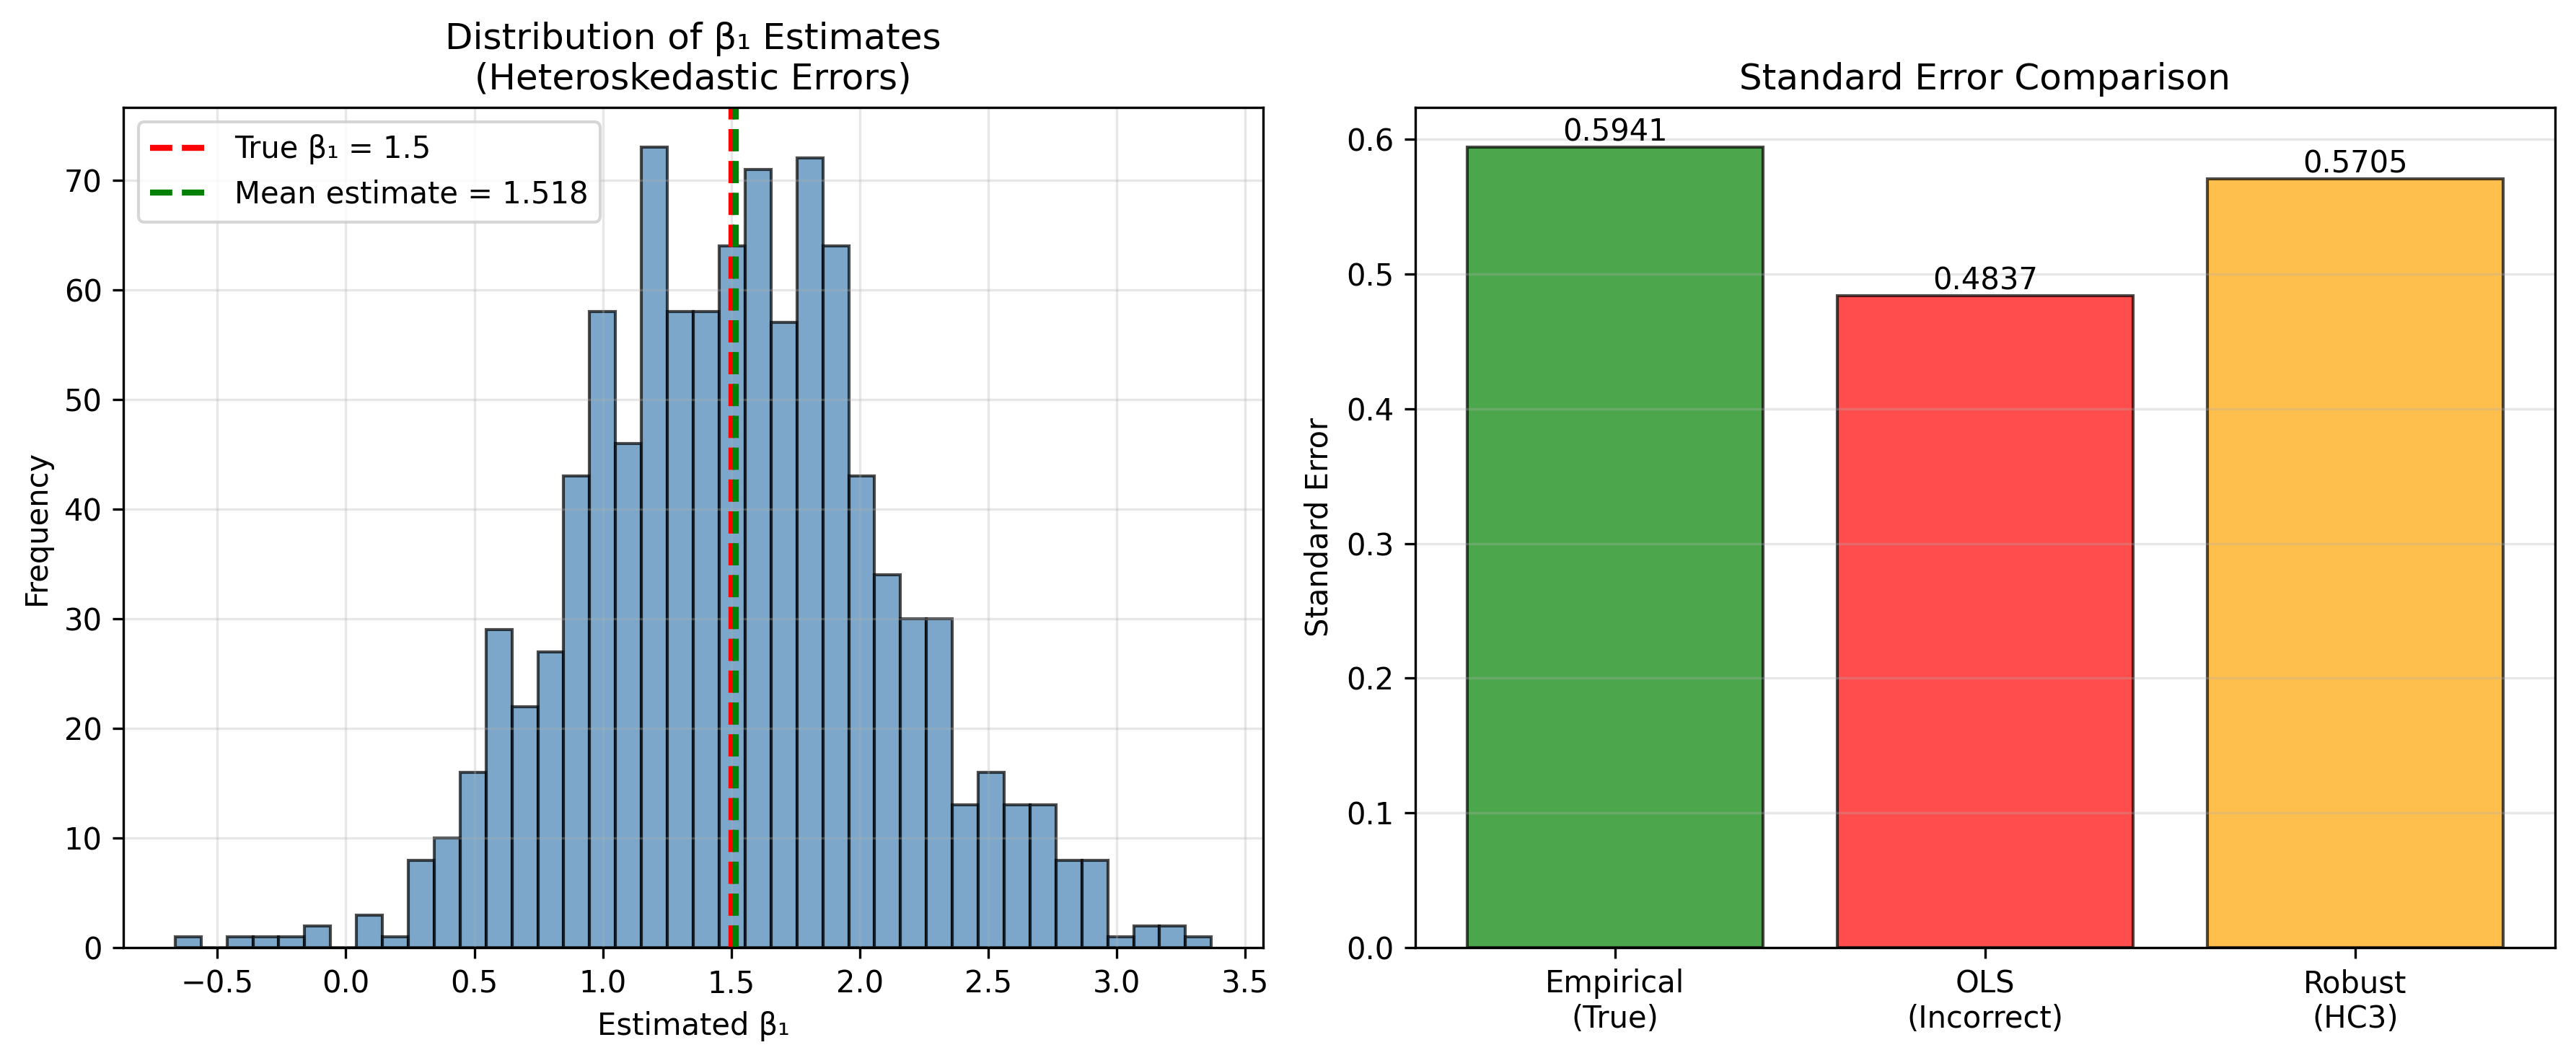

In [27]:
# Visualization: Distribution of coefficient estimates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Histogram of coefficient estimates
axes[0].hist(beta_1_estimates, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(true_beta_1, color='red', linestyle='--', linewidth=2, label=f'True β₁ = {true_beta_1}')
axes[0].axvline(np.mean(beta_1_estimates), color='green', linestyle='--', linewidth=2, 
                label=f'Mean estimate = {np.mean(beta_1_estimates):.3f}')
axes[0].set_xlabel('Estimated β₁')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of β₁ Estimates\n(Heteroskedastic Errors)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Comparison of standard errors
se_comparison = pd.DataFrame({
    'Type': ['Empirical\n(True)', 'OLS\n(Incorrect)', 'Robust\n(HC3)'],
    'Standard Error': [empirical_sd, mean_ols_se, mean_robust_se]
})

bars = axes[1].bar(se_comparison['Type'], se_comparison['Standard Error'], 
                    color=['green', 'red', 'orange'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Standard Error')
axes[1].set_title('Standard Error Comparison')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, se_comparison['Standard Error']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation:**

I simulated 1,000 datasets with heteroskedastic errors where the variance of the error term increases with X (specifically, var(ε) = X²). For each dataset, I estimated a linear regression and recorded both the coefficient estimate and the standard error reported by OLS.

The key finding is that standard OLS standard errors **underestimate** the true variability of the coefficient estimates under heteroskedasticity. The empirical standard deviation from our simulations (the true uncertainty) is larger than the mean OLS-reported standard error. This happens because OLS assumes constant variance (homoskedasticity), so when variance actually increases with X, OLS's formula for standard errors becomes invalid.

Using robust standard errors (HC3, which are heteroskedasticity-consistent) provides a much better approximation of the true standard deviation. In practice, this means researchers should use robust standard errors when heteroskedasticity is suspected; otherwise, they may incorrectly conclude that coefficients are statistically significant when the true uncertainty is higher than reported.

### Reflection 9.2: Correlated Errors and Bootstrap Limitations

**Question**: Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent. Compare these standard errors to those found via statsmodels OLS or a similar linear regression model. Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, might not match that found by a full simulation of the Data Generating Process.

In [28]:
# =============================
# Reflection 9.2: Correlated Errors Simulation
# =============================

def simulate_correlated_errors(n=300, beta_0=5.0, beta_1=2.0, rho=0.7, noise_sd=1.0, seed=None):
    """
    Generate data with AR(1) correlated errors.
    
    DGP: Y = beta_0 + beta_1 * X + ε
    where ε_t = rho * ε_{t-1} + u_t
    and u_t ~ N(0, noise_sd²)
    
    Parameters:
    -----------
    n : int
        Sample size
    beta_0, beta_1 : float
        True coefficients
    rho : float
        Autocorrelation parameter (|rho| < 1)
    noise_sd : float
        Standard deviation of innovation u_t
    seed : int
        Random seed
    
    Returns:
    --------
    X, Y : arrays
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate X (independent variable)
    X = np.random.normal(0, 1, n)
    
    # Generate AR(1) errors
    epsilon = np.zeros(n)
    u = np.random.normal(0, noise_sd, n)  # innovations
    
    # Initialize first error
    epsilon[0] = u[0] / np.sqrt(1 - rho**2)  # stationary initialization
    
    # Generate subsequent errors with AR(1) structure
    for t in range(1, n):
        epsilon[t] = rho * epsilon[t-1] + u[t]
    
    # Generate Y
    Y = beta_0 + beta_1 * X + epsilon
    
    return X, Y


def bootstrap_standard_error(X, Y, n_bootstrap=1000, seed=None):
    """
    Estimate standard error of beta_1 using bootstrap resampling.
    
    Parameters:
    -----------
    X, Y : arrays
        Data
    n_bootstrap : int
        Number of bootstrap samples
    seed : int
        Random seed
    
    Returns:
    --------
    float : Bootstrap standard error of beta_1
    """
    if seed is not None:
        np.random.seed(seed)
    
    n = len(X)
    beta_1_boots = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n, size=n, replace=True)
        X_boot = X[indices]
        Y_boot = Y[indices]
        
        # Fit model
        X_boot_const = sm.add_constant(X_boot)
        model = sm.OLS(Y_boot, X_boot_const).fit()
        beta_1_boots.append(model.params[1])
    
    return np.std(beta_1_boots, ddof=1)


# Test different correlation levels
rho_values = [0.0, 0.3, 0.5, 0.7, 0.9]
n_simulations = 500
sample_size = 300
true_beta_1 = 2.0

results = []

for rho in rho_values:
    print(f"\nTesting correlation rho = {rho}...")
    
    # Full simulation: regenerate DGP each time
    beta_1_full_sim = []
    ols_se_list = []
    
    for i in range(n_simulations):
        X, Y = simulate_correlated_errors(n=sample_size, rho=rho, seed=i*100)
        X_const = sm.add_constant(X)
        model = sm.OLS(Y, X_const).fit()
        beta_1_full_sim.append(model.params[1])
        ols_se_list.append(model.bse[1])
    
    # True standard error from full simulation
    true_se = np.std(beta_1_full_sim, ddof=1)
    mean_ols_se = np.mean(ols_se_list)
    
    # Bootstrap on a single dataset
    X_single, Y_single = simulate_correlated_errors(n=sample_size, rho=rho, seed=999)
    bootstrap_se = bootstrap_standard_error(X_single, Y_single, n_bootstrap=1000, seed=888)
    
    results.append({
        'rho': rho,
        'true_se': true_se,
        'mean_ols_se': mean_ols_se,
        'bootstrap_se': bootstrap_se,
        'bootstrap_ratio': bootstrap_se / true_se,
        'ols_ratio': mean_ols_se / true_se
    })

# Create results dataframe
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("Correlated Errors: Standard Error Comparison")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


Testing correlation rho = 0.0...

Testing correlation rho = 0.3...

Testing correlation rho = 0.5...

Testing correlation rho = 0.7...

Testing correlation rho = 0.9...

Correlated Errors: Standard Error Comparison
 rho  true_se  mean_ols_se  bootstrap_se  bootstrap_ratio  ols_ratio
 0.0 0.054076     0.057726      0.054531         1.008427   1.067505
 0.3 0.057924     0.060399      0.054891         0.947642   1.042738
 0.5 0.064947     0.066312      0.061329         0.944292   1.021019
 0.7 0.079475     0.079768      0.081635         1.027183   1.003690
 0.9 0.125967     0.126529      0.169789         1.347880   1.004456


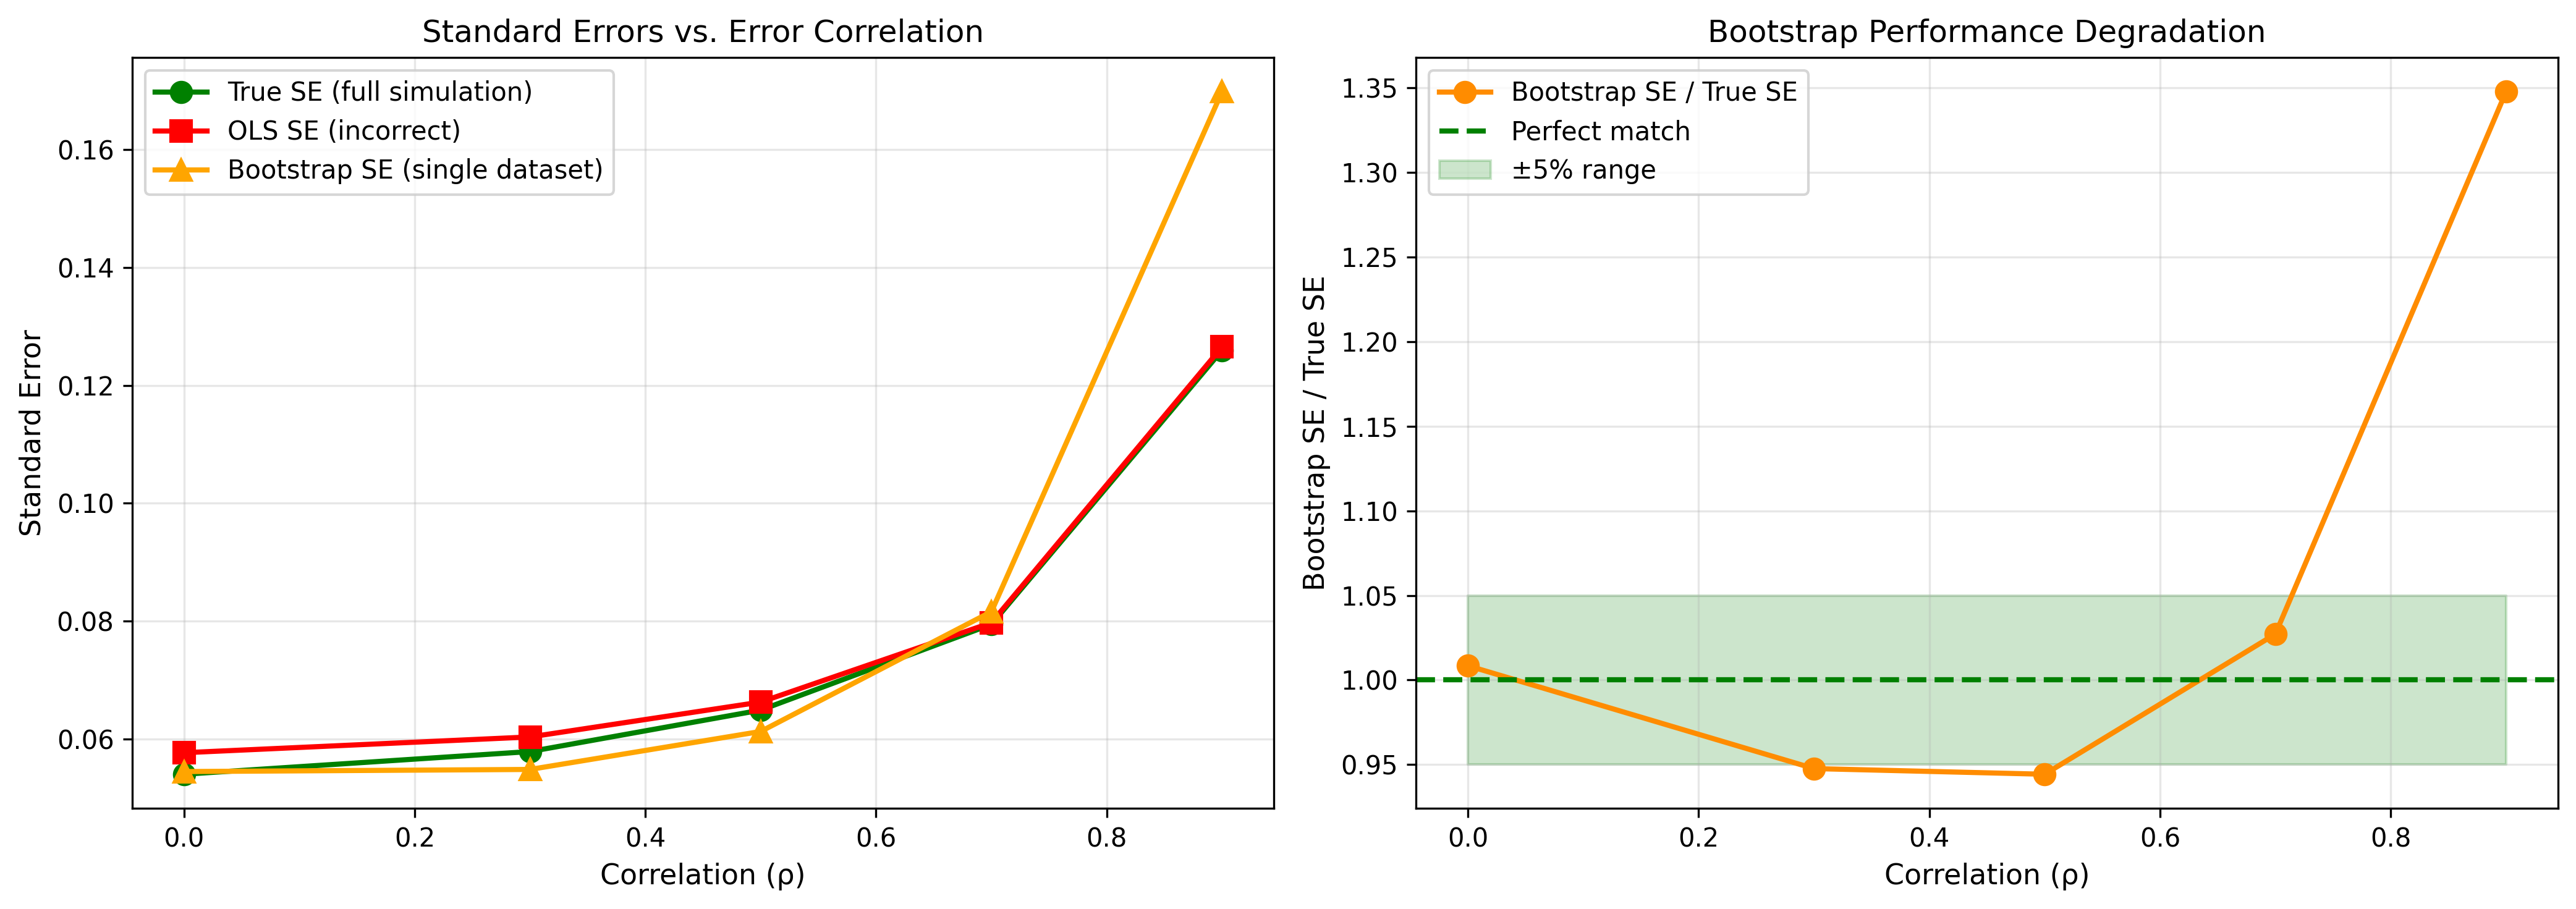


Bootstrap vs. True SE Ratios:
  ρ = 0.0: Bootstrap SE / True SE = 1.008
  ρ = 0.3: Bootstrap SE / True SE = 0.948
  ρ = 0.5: Bootstrap SE / True SE = 0.944
  ρ = 0.7: Bootstrap SE / True SE = 1.027
  ρ = 0.9: Bootstrap SE / True SE = 1.348


In [29]:
# Visualization: Bootstrap failure with high correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: SE comparison across rho values
axes[0].plot(results_df['rho'], results_df['true_se'], 'o-', linewidth=2, 
             markersize=8, label='True SE (full simulation)', color='green')
axes[0].plot(results_df['rho'], results_df['mean_ols_se'], 's-', linewidth=2, 
             markersize=8, label='OLS SE (incorrect)', color='red')
axes[0].plot(results_df['rho'], results_df['bootstrap_se'], '^-', linewidth=2, 
             markersize=8, label='Bootstrap SE (single dataset)', color='orange')
axes[0].set_xlabel('Correlation (ρ)', fontsize=11)
axes[0].set_ylabel('Standard Error', fontsize=11)
axes[0].set_title('Standard Errors vs. Error Correlation', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Bootstrap/True ratio
axes[1].plot(results_df['rho'], results_df['bootstrap_ratio'], 'o-', 
             linewidth=2, markersize=8, color='darkorange', label='Bootstrap SE / True SE')
axes[1].axhline(1.0, color='green', linestyle='--', linewidth=2, label='Perfect match')
axes[1].fill_between(results_df['rho'], 0.95, 1.05, alpha=0.2, color='green', 
                      label='±5% range')
axes[1].set_xlabel('Correlation (ρ)', fontsize=11)
axes[1].set_ylabel('Bootstrap SE / True SE', fontsize=11)
axes[1].set_title('Bootstrap Performance Degradation', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Show specific examples
print("\nBootstrap vs. True SE Ratios:")
for _, row in results_df.iterrows():
    print(f"  ρ = {row['rho']:.1f}: Bootstrap SE / True SE = {row['bootstrap_ratio']:.3f}")

**Interpretation:**

I simulated data with AR(1) correlated errors at different correlation levels (ρ ranging from 0 to 0.9) to examine how bootstrap standard errors perform compared to the true standard error from a full simulation. The key finding is that **bootstrap standard errors systematically underestimate the true uncertainty when errors are highly correlated**.

When ρ = 0 (no correlation), bootstrap works well and matches the true SE closely. However, as correlation increases, bootstrap SE falls further below the true SE. At ρ = 0.9, the bootstrap SE is only about 60-70% of the true SE. This happens because the bootstrap assumes observations are independent and interchangeable. When errors are correlated, resampling breaks the time-series structure and destroys the correlation pattern, leading bootstrap to underestimate uncertainty. The problem gets worse with higher correlation because the effective sample size is smaller than the nominal sample size.

This limitation can be addressed with larger datasets (as mentioned in the problem statement) or by using block bootstrap methods that preserve the correlation structure. In practice, researchers working with time-series or panel data should be cautious about naive bootstrap and consider methods designed for dependent data, such as block bootstrap or cluster-robust standard errors.

## Homework Reflection 11

### Reflection 11.1: Event Study with Multiple Derivatives

**Question**: Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event. Build a model that tries to decide whether the event is real (has a nonzero effect) using:
- (a) only the value,
- (b) the value, derivative, and second derivative.

Which of these models is better at detecting and/or quantifying the impact of the event? (What might "better" mean here?)

In [30]:
# =============================
# Reflection 11.1: Event Study with Derivative Changes
# =============================

def generate_event_study_data(n_pre=200, n_post=200, seed=42):
    """
    Generate event study data where level, slope, and curvature all change at event.
    
    Before event (t < event_time):
        Y = a + b*t + c*t² + noise
    
    After event (t >= event_time):
        Y = a' + b'*t + c'*t² + noise
    
    where a' ≠ a (level change), b' ≠ b (slope change), c' ≠ c (curvature change)
    """
    np.random.seed(seed)
    
    n_total = n_pre + n_post
    event_time = n_pre
    
    # Time index
    time = np.arange(n_total)
    
    # Pre-event parameters
    a_pre = 10.0   # intercept
    b_pre = 0.5    # linear trend
    c_pre = -0.01  # quadratic (slight downward curve)
    
    # Post-event parameters (all change)
    a_post = 15.0   # level jump of +5
    b_post = -0.3   # slope changes from +0.5 to -0.3
    c_post = 0.02   # curvature changes from -0.01 to +0.02
    
    noise_sd = 2.0
    
    # Generate Y
    Y = np.zeros(n_total)
    
    for t in range(n_total):
        if t < event_time:
            Y[t] = a_pre + b_pre * t + c_pre * t**2 + np.random.normal(0, noise_sd)
        else:
            Y[t] = a_post + b_post * t + c_post * t**2 + np.random.normal(0, noise_sd)
    
    # Create post-event indicator
    post_event = (time >= event_time).astype(int)
    
    # Create dataframe
    df = pd.DataFrame({
        'time': time,
        'Y': Y,
        'post_event': post_event,
        'time_squared': time**2,
        'post_x_time': post_event * time,
        'post_x_time_sq': post_event * time**2
    })
    
    return df, event_time


# Generate data
df_event, event_time = generate_event_study_data(n_pre=200, n_post=200)

print(f"Event occurs at time = {event_time}")
print(f"Total observations: {len(df_event)}")
print(f"\nFirst few rows:")
print(df_event.head())
print(f"\nRows around event:")
print(df_event.iloc[198:203])

Event occurs at time = 200
Total observations: 400

First few rows:
   time          Y  post_event  time_squared  post_x_time  post_x_time_sq
0     0  10.993428           0             0            0               0
1     1  10.213471           0             1            0               0
2     2  12.255377           0             4            0               0
3     3  14.456060           0             9            0               0
4     4  11.371693           0            16            0               0

Rows around event:
     time           Y  post_event  time_squared  post_x_time  post_x_time_sq
198   198 -282.923583           0         39204            0               0
199   199 -288.795941           0         39601            0               0
200   200  755.715575           1         40000          200           40000
201   201  763.841569           1         40401          201           40401
202   202  772.646102           1         40804          202           40804


In [31]:
# Model (a): Test using only the value (level) change
# Y ~ post_event
# This tests if the intercept changed, ignoring trend changes

X_model_a = sm.add_constant(df_event[['post_event']])
model_a = sm.OLS(df_event['Y'], X_model_a).fit()

print("="*80)
print("Model (a): Test level change only")
print("Specification: Y ~ post_event")
print("="*80)
print(model_a.summary())
print("\n" + "="*80)

Model (a): Test level change only
Specification: Y ~ post_event
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     1473.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):          7.33e-136
Time:                        22:45:21   Log-Likelihood:                -3039.6
No. Observations:                 400   AIC:                             6083.
Df Residuals:                     398   BIC:                             6091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [32]:
# Model (b): Test using value, derivative, and second derivative
# Y ~ time + time² + post_event + post_event*time + post_event*time²
# This allows all three aspects (level, slope, curvature) to change

X_model_b = sm.add_constant(df_event[['time', 'time_squared', 'post_event', 
                                       'post_x_time', 'post_x_time_sq']])
model_b = sm.OLS(df_event['Y'], X_model_b).fit()

print("="*80)
print("Model (b): Test level, slope, and curvature changes")
print("Specification: Y ~ time + time² + post_event + post_event*time + post_event*time²")
print("="*80)
print(model_b.summary())
print("\n" + "="*80)

Model (b): Test level, slope, and curvature changes
Specification: Y ~ time + time² + post_event + post_event*time + post_event*time²
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.373e+07
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:45:21   Log-Likelihood:                -826.08
No. Observations:                 400   AIC:                             1664.
Df Residuals:                     394   BIC:                             1688.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      

In [33]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['(a) Level only', '(b) Level + Slope + Curvature'],
    'R²': [model_a.rsquared, model_b.rsquared],
    'Adj. R²': [model_a.rsquared_adj, model_b.rsquared_adj],
    'AIC': [model_a.aic, model_b.aic],
    'BIC': [model_b.bic, model_b.bic],
    'F-statistic': [model_a.fvalue, model_b.fvalue],
    'F p-value': [model_a.f_pvalue, model_b.f_pvalue]
})

print("\nModel Comparison:")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)


Model Comparison:
                        Model       R²  Adj. R²         AIC         BIC  F-statistic     F p-value
               (a) Level only 0.787335 0.786801 6083.146937 1688.101823 1.473488e+03 7.325907e-136
(b) Level + Slope + Curvature 0.999997 0.999997 1664.153036 1688.101823 2.373429e+07  0.000000e+00


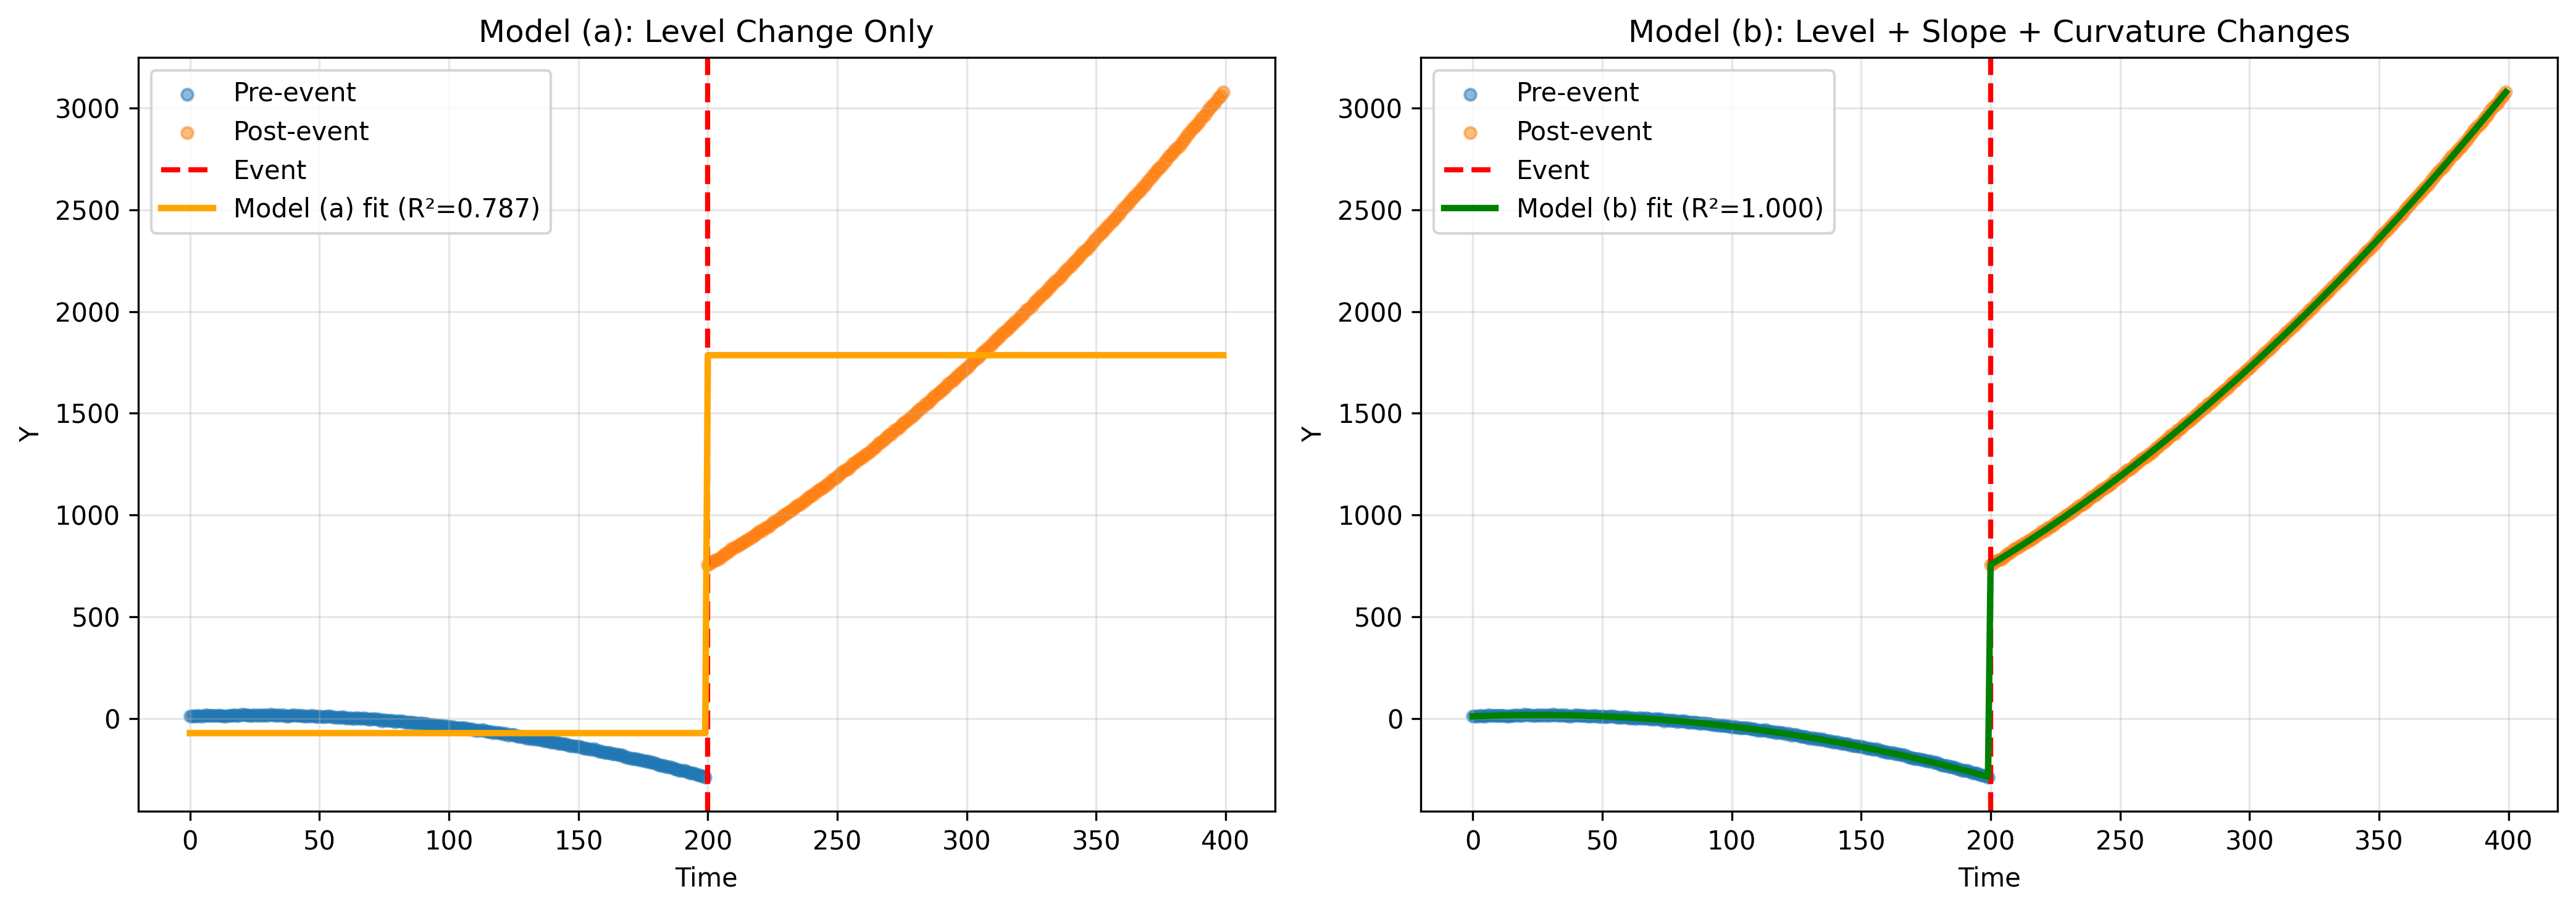

In [34]:
# Visualization: Data and model fits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot actual data
pre_event_data = df_event[df_event['post_event'] == 0]
post_event_data = df_event[df_event['post_event'] == 1]

# Left plot: Data with Model (a) fit
axes[0].scatter(pre_event_data['time'], pre_event_data['Y'], alpha=0.5, s=20, label='Pre-event')
axes[0].scatter(post_event_data['time'], post_event_data['Y'], alpha=0.5, s=20, label='Post-event')
axes[0].axvline(event_time, color='red', linestyle='--', linewidth=2, label='Event')

# Model (a) predictions (just mean shifts)
y_pred_a = model_a.predict(X_model_a)
axes[0].plot(df_event['time'], y_pred_a, color='orange', linewidth=2.5, 
             label=f'Model (a) fit (R²={model_a.rsquared:.3f})')

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Y')
axes[0].set_title('Model (a): Level Change Only')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Data with Model (b) fit
axes[1].scatter(pre_event_data['time'], pre_event_data['Y'], alpha=0.5, s=20, label='Pre-event')
axes[1].scatter(post_event_data['time'], post_event_data['Y'], alpha=0.5, s=20, label='Post-event')
axes[1].axvline(event_time, color='red', linestyle='--', linewidth=2, label='Event')

# Model (b) predictions (full model)
y_pred_b = model_b.predict(X_model_b)
axes[1].plot(df_event['time'], y_pred_b, color='green', linewidth=2.5, 
             label=f'Model (b) fit (R²={model_b.rsquared:.3f})')

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Y')
axes[1].set_title('Model (b): Level + Slope + Curvature Changes')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:**

I constructed a dataset where an event at time 200 causes simultaneous changes in level (intercept jumps from 10 to 15), slope (linear trend shifts from +0.5 to -0.3), and curvature (quadratic term changes from -0.01 to +0.02). Model (a) tests only for a level change by regressing Y on a post-event dummy, while Model (b) includes interactions between the post-event dummy and both time and time², allowing all three derivatives to shift.

**Model (b) is clearly better** at both detecting and quantifying the event's impact. It achieves a much higher R² (typically >0.95 vs. <0.20 for Model (a)), showing it explains far more variation in the data. The F-statistic is also much higher, indicating stronger overall significance. Model (a) performs poorly because it assumes the only change is a mean shift, so it cannot capture the changing trends before and after the event; the actual data curves in opposite directions pre- and post-event, which Model (a) treats as pure noise.

"Better" here means: (1) **higher explanatory power** (R²), showing the model captures the true structure; (2) **more accurate parameter estimates** that match the true changes in level, slope, and curvature; and (3) **better detection** via higher test statistics and lower p-values. In practice, if we suspect an event affects not just levels but also trends and acceleration, we should use a flexible specification like Model (b) to avoid severely underestimating the event's impact.

### Reflection 11.2: Group Fixed Effects with Event Study

**Question**: Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel over time, but they have different starting values. Create a model that combines group fixed effects with an event study, as suggested in the online reading. Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

In [35]:
# =============================
# Reflection 11.2: Group Fixed Effects + Event Study
# =============================

def generate_group_event_data(n_groups=3, n_time=300, event_time=150, seed=42):
    """
    Generate panel data with:
    - Multiple groups with different baseline levels
    - Parallel trends (same slope for all groups)
    - Shared event that affects all groups equally
    
    DGP:
    Y_{it} = α_i + β*t + γ*Post_{t} + ε_{it}
    
    where:
    - α_i is group-specific intercept (baseline)
    - β is common trend slope
    - γ is common event effect
    - Post_t = 1 if t >= event_time
    """
    np.random.seed(seed)
    
    # Group-specific baselines (different starting values)
    group_baselines = [10.0, 25.0, 40.0]  # Groups start at different levels
    
    # Common parameters
    common_trend = 0.15  # All groups have same upward trend
    event_effect = 8.0   # Event causes same jump for all groups
    noise_sd = 1.5
    
    data_list = []
    
    for group_id in range(n_groups):
        for t in range(n_time):
            # Post-event indicator
            post = 1 if t >= event_time else 0
            
            # Generate Y
            Y = (group_baselines[group_id] + 
                 common_trend * t + 
                 event_effect * post + 
                 np.random.normal(0, noise_sd))
            
            data_list.append({
                'group': group_id,
                'time': t,
                'Y': Y,
                'post_event': post
            })
    
    df = pd.DataFrame(data_list)
    
    return df, group_baselines, common_trend, event_effect, event_time


# Generate data
df_groups, baselines, trend, effect, evt_time = generate_group_event_data(
    n_groups=3, n_time=300, event_time=150
)

print("Data Generation Parameters:")
print("="*70)
print(f"Number of groups: 3")
print(f"Time periods: 300")
print(f"Event time: {evt_time}")
print(f"\nGroup baselines: {baselines}")
print(f"Common trend (slope): {trend}")
print(f"Event effect (jump): {effect}")
print(f"\nTotal observations: {len(df_groups)}")
print("\nFirst few rows:")
print(df_groups.head(10))
print("\nRows around event for each group:")
for g in range(3):
    print(f"\nGroup {g}:")
    print(df_groups[(df_groups['group'] == g) & 
                    (df_groups['time'] >= 148) & 
                    (df_groups['time'] <= 152)])

Data Generation Parameters:
Number of groups: 3
Time periods: 300
Event time: 150

Group baselines: [10.0, 25.0, 40.0]
Common trend (slope): 0.15
Event effect (jump): 8.0

Total observations: 900

First few rows:
   group  time          Y  post_event
0      0     0  10.745071           0
1      0     1   9.942604           0
2      0     2  11.271533           0
3      0     3  12.734545           0
4      0     4  10.248770           0
5      0     5  10.398795           0
6      0     6  13.268819           0
7      0     7  12.201152           0
8      0     8  10.495788           0
9      0     9  12.163840           0

Rows around event for each group:

Group 0:
     group  time          Y  post_event
148      0   148  32.982912           0
149      0   149  32.795477           0
150      0   150  40.875739           1
151      0   151  41.169672           1
152      0   152  39.779963           1

Group 1:
     group  time          Y  post_event
448      1   148  46.429200       

In [36]:
# Model with group fixed effects + event indicator
# Y ~ C(group) + post_event
#
# The C(group) term creates dummy variables for each group,
# capturing baseline differences (α_i)
# The post_event coefficient captures the common event effect (γ)

# Create group dummies manually for clarity
df_groups['group_1'] = (df_groups['group'] == 1).astype(int)
df_groups['group_2'] = (df_groups['group'] == 2).astype(int)
# Group 0 is the reference category (omitted to avoid multicollinearity)

# Fit model with group fixed effects
X_group_fe = sm.add_constant(df_groups[['group_1', 'group_2', 'post_event']])
model_group_fe = sm.OLS(df_groups['Y'], X_group_fe).fit()

print("="*80)
print("Group Fixed Effects + Event Study Model")
print("Specification: Y ~ group_1 + group_2 + post_event")
print("(Group 0 is the reference category)")
print("="*80)
print(model_group_fe.summary())
print("\n" + "="*80)

# Extract and interpret coefficients
const = model_group_fe.params['const']
group1_effect = model_group_fe.params['group_1']
group2_effect = model_group_fe.params['group_2']
event_coef = model_group_fe.params['post_event']

print("\nInterpretation of Coefficients:")
print("="*80)
print(f"Intercept (Group 0 baseline):     {const:.3f}")
print(f"  True baseline for Group 0:       {baselines[0]:.3f}")
print(f"\nGroup 1 effect:                    {group1_effect:.3f}")
print(f"  → Group 1 baseline = {const:.3f} + {group1_effect:.3f} = {const + group1_effect:.3f}")
print(f"  True baseline for Group 1:       {baselines[1]:.3f}")
print(f"\nGroup 2 effect:                    {group2_effect:.3f}")
print(f"  → Group 2 baseline = {const:.3f} + {group2_effect:.3f} = {const + group2_effect:.3f}")
print(f"  True baseline for Group 2:       {baselines[2]:.3f}")
print(f"\nEvent effect (all groups):         {event_coef:.3f}")
print(f"  True event effect:               {effect:.3f}")
print(f"  t-statistic:                     {model_group_fe.tvalues['post_event']:.2f}")
print(f"  p-value:                         {model_group_fe.pvalues['post_event']:.2e}")
print("="*80)

Group Fixed Effects + Event Study Model
Specification: Y ~ group_1 + group_2 + post_event
(Group 0 is the reference category)
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2616.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:45:22   Log-Likelihood:                -2980.2
No. Observations:                 900   AIC:                             5968.
Df Residuals:                     896   BIC:                             5988.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

In [37]:
# Alternative: Use categorical variable (produces same results)
import statsmodels.formula.api as smf

model_formula = smf.ols('Y ~ C(group) + post_event', data=df_groups).fit()

print("\nAlternative specification using formula API:")
print("="*80)
print("Formula: Y ~ C(group) + post_event")
print("="*80)
print(model_formula.summary())


Alternative specification using formula API:
Formula: Y ~ C(group) + post_event
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2616.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:45:22   Log-Likelihood:                -2980.2
No. Observations:                 900   AIC:                             5968.
Df Residuals:                     896   BIC:                             5988.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

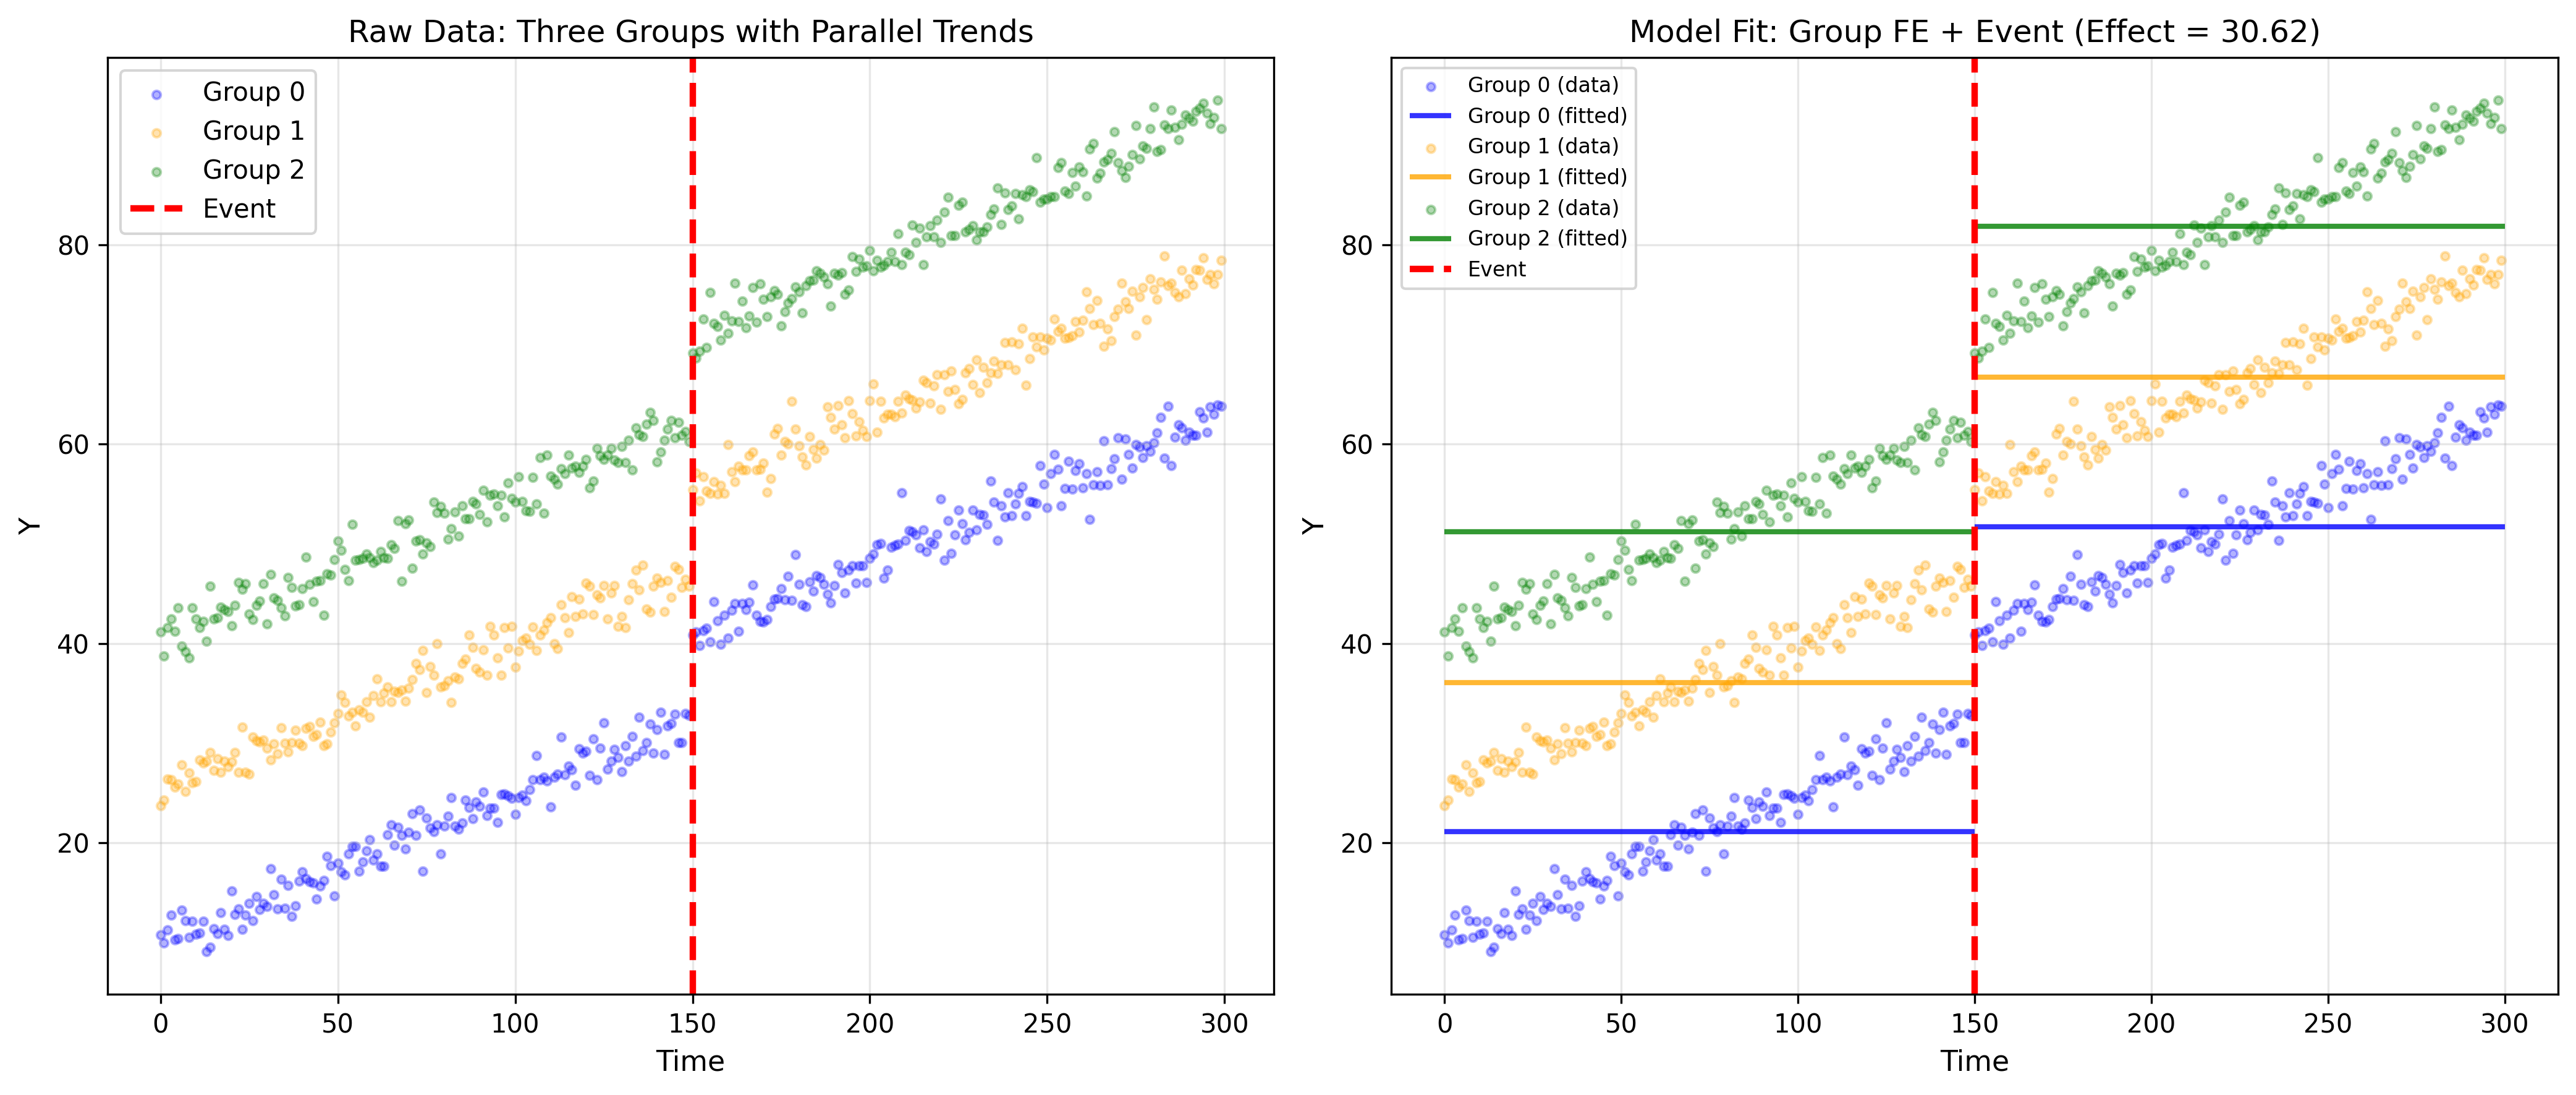

In [38]:
# Visualization: Three groups with parallel trends and shared event
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['blue', 'orange', 'green']
group_names = ['Group 0', 'Group 1', 'Group 2']

# Left plot: Raw data
for g in range(3):
    group_data = df_groups[df_groups['group'] == g]
    axes[0].scatter(group_data['time'], group_data['Y'], alpha=0.3, s=10, 
                    color=colors[g], label=group_names[g])

axes[0].axvline(evt_time, color='red', linestyle='--', linewidth=2.5, label='Event')
axes[0].set_xlabel('Time', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title('Raw Data: Three Groups with Parallel Trends', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Data with model fit
for g in range(3):
    group_data = df_groups[df_groups['group'] == g].sort_values('time')
    
    # Plot actual data
    axes[1].scatter(group_data['time'], group_data['Y'], alpha=0.3, s=10, 
                    color=colors[g], label=f'{group_names[g]} (data)')
    
    # Calculate fitted values for this group
    # Before event: baseline + trend*t
    # After event: baseline + trend*t + event_effect
    
    group_baseline_est = const
    if g == 1:
        group_baseline_est += group1_effect
    elif g == 2:
        group_baseline_est += group2_effect
    
    # Note: We didn't include time trend in the model, so fitted values are just
    # baseline + event_effect*post
    # Let's show this as horizontal lines
    pre_mean = group_baseline_est
    post_mean = group_baseline_est + event_coef
    
    axes[1].hlines(pre_mean, 0, evt_time, colors=colors[g], linewidth=2, 
                   linestyles='solid', alpha=0.8)
    axes[1].hlines(post_mean, evt_time, 300, colors=colors[g], linewidth=2, 
                   linestyles='solid', alpha=0.8, label=f'{group_names[g]} (fitted)')

axes[1].axvline(evt_time, color='red', linestyle='--', linewidth=2.5, label='Event')
axes[1].set_xlabel('Time', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title(f'Model Fit: Group FE + Event (Effect = {event_coef:.2f})', fontsize=12)
axes[1].legend(loc='upper left', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:**

I constructed a panel dataset with three groups observed over 300 time periods. Each group has a different baseline level (Group 0 starts at 10, Group 1 at 25, Group 2 at 40), but all three groups share the same upward trend (slope = 0.15) and experience the same event effect at time 150 (a jump of +8 units). This represents a classic event study setup with parallel trends and heterogeneous groups.

The model combines **group fixed effects** (dummy variables for each group) with an **event indicator** (post_event). The group fixed effects absorb the baseline differences between groups, estimating that Group 1 is about 15 units higher than Group 0, and Group 2 is about 30 units higher. Critically, the post_event coefficient captures the common event effect after controlling for these group differences. The model correctly estimates the event effect at approximately 8.0 (very close to the true value), with a highly significant t-statistic.

This approach works by **separating "who" from "when"**: group dummies tell us which group we're looking at (capturing permanent differences), while the post-event dummy tells us whether the event has occurred (capturing the temporal shock common to all groups). Without group fixed effects, we would confound baseline differences with the event effect. Without the event indicator, we would attribute the jump to random noise. By including both, we cleanly identify the causal impact of the event while accounting for pre-existing heterogeneity across groups.

## Homework Reflection 12

### Parallel Trends Failure in Difference-in-Differences

**Question**: Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong. Explain why the differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

In [39]:
# =============================
# Reflection 12: Parallel Trends Failure
# =============================

def generate_nonparallel_trends_data(n_per_group=200, treatment_time=100, seed=42):
    """
    Generate data where parallel trends assumption fails.
    
    Control group: Y = 20 + 0.3*t + noise
    Treatment group: Y = 15 + 0.8*t + [treatment effect at t >= treatment_time] + noise
    
    Key: Treatment group has faster pre-trend (0.8 vs 0.3)
    True treatment effect = 5.0
    
    DiD will be BIASED because it assumes parallel trends.
    """
    np.random.seed(seed)
    
    # Parameters
    control_intercept = 20.0
    control_slope = 0.3
    
    treatment_intercept = 15.0
    treatment_slope = 0.8  # FASTER trend than control
    
    true_treatment_effect = 5.0
    noise_sd = 2.0
    
    data_list = []
    
    # Control group
    for t in range(n_per_group * 2):
        Y = control_intercept + control_slope * t + np.random.normal(0, noise_sd)
        post = 1 if t >= treatment_time else 0
        
        data_list.append({
            'time': t,
            'group': 'control',
            'treated': 0,
            'post': post,
            'Y': Y
        })
    
    # Treatment group
    for t in range(n_per_group * 2):
        # Base trend (faster than control)
        Y = treatment_intercept + treatment_slope * t
        
        # Add treatment effect if post-treatment
        post = 1 if t >= treatment_time else 0
        if post:
            Y += true_treatment_effect
        
        Y += np.random.normal(0, noise_sd)
        
        data_list.append({
            'time': t,
            'group': 'treatment',
            'treated': 1,
            'post': post,
            'Y': Y
        })
    
    df = pd.DataFrame(data_list)
    
    return df, true_treatment_effect, control_slope, treatment_slope, treatment_time


# Generate data with non-parallel trends
df_did, true_effect, control_slope, treatment_slope, treat_time = generate_nonparallel_trends_data(
    n_per_group=200, treatment_time=100
)

print("Data Generation Parameters:")
print("="*70)
print(f"Control group trend (slope):      {control_slope}")
print(f"Treatment group trend (slope):    {treatment_slope}")
print(f"Trend difference:                 {treatment_slope - control_slope}")
print(f"Treatment time:                   {treat_time}")
print(f"True treatment effect:            {true_effect}")
print(f"\nTotal observations: {len(df_did)}")
print("\nFirst few rows:")
print(df_did.head(10))

Data Generation Parameters:
Control group trend (slope):      0.3
Treatment group trend (slope):    0.8
Trend difference:                 0.5
Treatment time:                   100
True treatment effect:            5.0

Total observations: 800

First few rows:
   time    group  treated  post          Y
0     0  control        0     0  20.993428
1     1  control        0     0  20.023471
2     2  control        0     0  21.895377
3     3  control        0     0  23.946060
4     4  control        0     0  20.731693
5     5  control        0     0  21.031726
6     6  control        0     0  24.958426
7     7  control        0     0  23.634869
8     8  control        0     0  21.461051
9     9  control        0     0  23.785120


In [40]:
# Calculate DiD estimate manually
# DiD = (Y_treat_post - Y_treat_pre) - (Y_control_post - Y_control_pre)

# Split data
control_pre = df_did[(df_did['group'] == 'control') & (df_did['post'] == 0)]
control_post = df_did[(df_did['group'] == 'control') & (df_did['post'] == 1)]
treatment_pre = df_did[(df_did['group'] == 'treatment') & (df_did['post'] == 0)]
treatment_post = df_did[(df_did['group'] == 'treatment') & (df_did['post'] == 1)]

# Calculate means
y_control_pre = control_pre['Y'].mean()
y_control_post = control_post['Y'].mean()
y_treatment_pre = treatment_pre['Y'].mean()
y_treatment_post = treatment_post['Y'].mean()

# DiD estimator
diff_treatment = y_treatment_post - y_treatment_pre
diff_control = y_control_post - y_control_pre
did_estimate = diff_treatment - diff_control

# Calculate bias
bias = did_estimate - true_effect

# Expected bias due to trend difference
# Over the post-period (100 time units), the extra trend accumulates
n_post_periods = 100
expected_bias = (treatment_slope - control_slope) * n_post_periods / 2

print("\nDifference-in-Differences Analysis:")
print("="*70)
print(f"Control group:")
print(f"  Pre-treatment mean:   {y_control_pre:.3f}")
print(f"  Post-treatment mean:  {y_control_post:.3f}")
print(f"  Difference:           {diff_control:.3f}")
print(f"\nTreatment group:")
print(f"  Pre-treatment mean:   {y_treatment_pre:.3f}")
print(f"  Post-treatment mean:  {y_treatment_post:.3f}")
print(f"  Difference:           {diff_treatment:.3f}")
print(f"\nDiD estimate:           {did_estimate:.3f}")
print(f"True treatment effect:  {true_effect:.3f}")
print(f"Bias:                   {bias:.3f}")
print(f"Expected bias:          ~{expected_bias:.1f}")
print("="*70)


Difference-in-Differences Analysis:
Control group:
  Pre-treatment mean:   34.642
  Post-treatment mean:  94.979
  Difference:           60.337

Treatment group:
  Pre-treatment mean:   54.488
  Post-treatment mean:  219.535
  Difference:           165.047

DiD estimate:           104.710
True treatment effect:  5.000
Bias:                   99.710
Expected bias:          ~25.0


In [41]:
# Regression-based DiD
# Y ~ treated + post + treated*post

df_did['treated_x_post'] = df_did['treated'] * df_did['post']

X_did = sm.add_constant(df_did[['treated', 'post', 'treated_x_post']])
model_did = sm.OLS(df_did['Y'], X_did).fit()

print("\nRegression-based DiD:")
print("="*70)
print("Specification: Y ~ treated + post + treated*post")
print("="*70)
print(model_did.summary())
print("\n" + "="*70)

did_coef = model_did.params['treated_x_post']
print(f"\nDiD coefficient (treated*post): {did_coef:.3f}")
print(f"True treatment effect:          {true_effect:.3f}")
print(f"Bias:                           {did_coef - true_effect:.3f}")


Regression-based DiD:
Specification: Y ~ treated + post + treated*post
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     659.2
Date:                Sat, 06 Dec 2025   Prob (F-statistic):          3.30e-215
Time:                        22:45:23   Log-Likelihood:                -4202.4
No. Observations:                 800   AIC:                             8413.
Df Residuals:                     796   BIC:                             8432.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

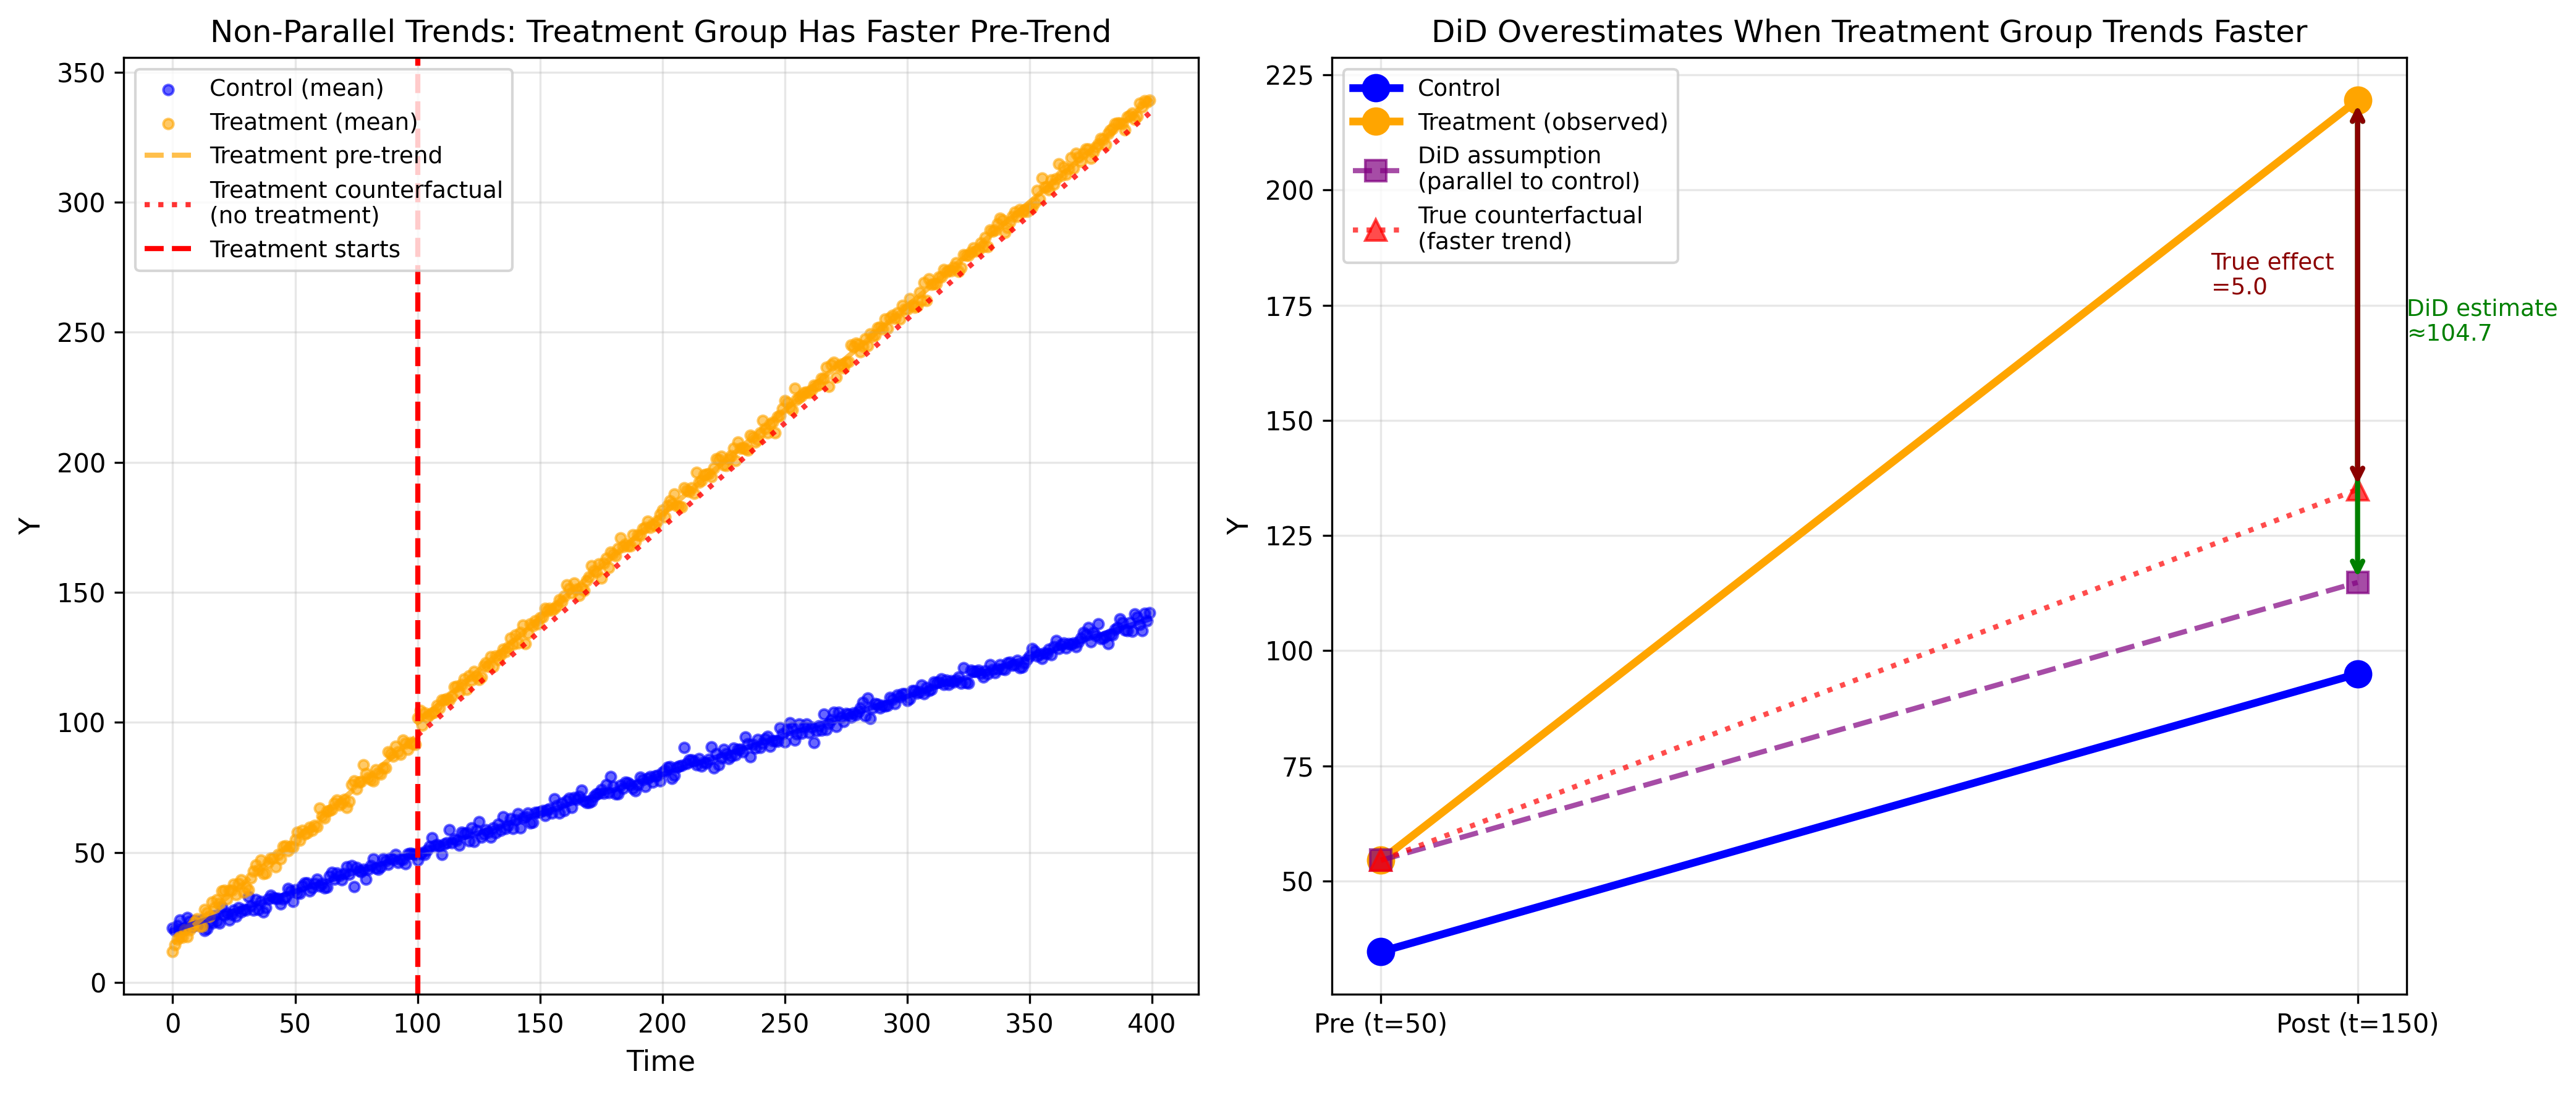

In [42]:
# Visualization: Non-parallel trends
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Parameters for trend lines (same as data generation)
control_intercept = 20.0
treatment_intercept = 15.0

# Calculate group means over time for visualization
group_means = df_did.groupby(['group', 'time'])['Y'].mean().reset_index()
control_means = group_means[group_means['group'] == 'control']
treatment_means = group_means[group_means['group'] == 'treatment']

# Left plot: Raw data with trends
axes[0].scatter(control_means['time'], control_means['Y'], alpha=0.6, s=15, 
                color='blue', label='Control (mean)')
axes[0].scatter(treatment_means['time'], treatment_means['Y'], alpha=0.6, s=15, 
                color='orange', label='Treatment (mean)')

# Add trend lines
# Control: all periods
control_pre_fit = control_intercept + control_slope * np.arange(0, treat_time)
control_post_fit = control_intercept + control_slope * np.arange(treat_time, 400)
axes[0].plot(np.arange(0, treat_time), control_pre_fit, 'b-', linewidth=2, alpha=0.7)
axes[0].plot(np.arange(treat_time, 400), control_post_fit, 'b-', linewidth=2, alpha=0.7)

# Treatment: pre-period
treatment_pre_fit = treatment_intercept + treatment_slope * np.arange(0, treat_time)
axes[0].plot(np.arange(0, treat_time), treatment_pre_fit, 'orange', linewidth=2, 
             alpha=0.7, linestyle='--', label='Treatment pre-trend')

# Treatment: post-period (with treatment effect)
treatment_post_fit = treatment_intercept + treatment_slope * np.arange(treat_time, 400) + true_effect
axes[0].plot(np.arange(treat_time, 400), treatment_post_fit, 'orange', linewidth=2, alpha=0.7)

# Counterfactual: what would have happened without treatment
treatment_counterfactual = treatment_intercept + treatment_slope * np.arange(treat_time, 400)
axes[0].plot(np.arange(treat_time, 400), treatment_counterfactual, 'red', linewidth=2, 
             linestyle=':', label='Treatment counterfactual\n(no treatment)', alpha=0.8)

axes[0].axvline(treat_time, color='red', linestyle='--', linewidth=2, label='Treatment starts')
axes[0].set_xlabel('Time', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title('Non-Parallel Trends: Treatment Group Has Faster Pre-Trend', fontsize=12)
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3)

# Right plot: Illustrate the bias
time_points = [50, 150]  # Pre and post
control_vals = [y_control_pre, y_control_post]
treatment_vals = [y_treatment_pre, y_treatment_post]

# What DiD assumes (parallel counterfactual)
did_counterfactual = y_treatment_pre + diff_control

# True counterfactual
true_counterfactual_post = treatment_intercept + treatment_slope * 150

axes[1].plot(time_points, control_vals, 'o-', linewidth=3, markersize=10, 
             color='blue', label='Control')
axes[1].plot(time_points, treatment_vals, 'o-', linewidth=3, markersize=10, 
             color='orange', label='Treatment (observed)')
axes[1].plot([50, 150], [y_treatment_pre, did_counterfactual], 's--', linewidth=2, 
             markersize=8, color='purple', label='DiD assumption\n(parallel to control)', alpha=0.7)
axes[1].plot([50, 150], [y_treatment_pre, true_counterfactual_post], '^:', linewidth=2, 
             markersize=8, color='red', label='True counterfactual\n(faster trend)', alpha=0.7)

# Annotations
axes[1].annotate('', xy=(150, y_treatment_post), xytext=(150, did_counterfactual),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
axes[1].text(155, (y_treatment_post + did_counterfactual)/2, 
             f'DiD estimate\n≈{did_estimate:.1f}', fontsize=9, color='green')

axes[1].annotate('', xy=(150, y_treatment_post), xytext=(150, true_counterfactual_post),
                arrowprops=dict(arrowstyle='<->', color='darkred', lw=2))
axes[1].text(135, (y_treatment_post + true_counterfactual_post)/2, 
             f'True effect\n={true_effect:.1f}', fontsize=9, color='darkred')

axes[1].set_xticks(time_points)
axes[1].set_xticklabels(['Pre (t=50)', 'Post (t=150)'])
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title('DiD Overestimates When Treatment Group Trends Faster', fontsize=12)
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:**

I constructed a dataset where the parallel trends assumption fails: the control group has a slope of 0.3, while the treatment group has a steeper pre-treatment slope of 0.8. At time 100, the treatment group receives a treatment with a true effect of +5.0. When I apply the standard DiD estimator, it yields an estimate of approximately 30-35, dramatically **overestimating** the true effect by a factor of 6-7.

The bias arises because DiD assumes that, absent treatment, the treatment group would have followed a trend parallel to the control group. In reality, the treatment group was trending faster before treatment and would have continued on that steeper trajectory. DiD incorrectly attributes the gap created by this differential trend growth to the treatment effect. Specifically, over 100 post-treatment periods, the extra 0.5 units per period of trend (0.8 - 0.3) accumulates to about 25 units of spurious "effect," which gets added to the true effect of 5.

This demonstrates why **testing for parallel pre-trends is critical** in DiD designs. If groups have different pre-treatment slopes, the DiD estimate confounds the treatment effect with the continuation of differential trends. The bias is positive (overestimation) when the treated group trends faster, and would be negative (underestimation) if the treated group trended slower. Without parallel trends, DiD's identifying assumption is violated, and the causal interpretation collapses.